In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Read beam simulation file

In [2]:
# Read beam simulation generated by David Woody, from Marin Anderson
with open('/Users/ruby/Astro/LWA_beams/DW_beamquadranttable20151110.txt', 'r') as f:
    lines = f.readlines()
f.close()

In [3]:
header = lines[6]
npoints = len(lines)-7

za_deg = np.zeros(npoints, dtype=float)
az_deg = np.zeros(npoints, dtype=float)
freq_mhz = np.zeros(npoints, dtype=float)
jones_theta = np.zeros(npoints, dtype=complex)
jones_phi = np.zeros(npoints, dtype=complex)

In [4]:
for point in range(npoints):
    line_data = [float(value) for value in lines[point+7].split()]
    za_deg[point] = line_data[0]
    az_deg[point] = line_data[1]
    freq_mhz[point] = line_data[2]
    jones_theta[point] = line_data[7] + 1j*line_data[8]
    jones_phi[point] = line_data[9] + 1j*line_data[10]

# Format as a 4x4 Jones matrix and plot

In [5]:
za_axis = np.arange(0., 90.+5., 5.)
az_axis = np.arange(0., 360., 5.)
freq_axis = np.arange(20., 80.+10., 10.)
jones = np.full((2, 2, len(freq_axis), len(za_axis), len(az_axis)), np.nan+1j*np.nan, dtype=complex)

# Flip the Jones matrix in particular quadrants to get the correct sign convention
multiply_factors = np.ones((2, 2, 4), dtype=float)  # Shape (nfeeds, npols, nquadrants)
multiply_factors[0, 0, 0:2] = -1.
multiply_factors[0, 1, 1:3] = -1.
multiply_factors[1, 0, 0] = -1
multiply_factors[1, 0, 3] = -1
multiply_factors[1, 1, 0:2] = -1

for point in range(npoints):
    za_ind = np.where(za_axis == za_deg[point])
    freq_ind = np.where(freq_axis == freq_mhz[point])
    for pol in [0, 1]:
        use_az = az_deg[point]
        if pol == 0:
            use_az = 90.-use_az  # Q pol is rotated 90 degrees

        az_ind_quad_1 = np.where(az_axis == use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_1] = multiply_factors[0, pol, 0]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_1] = multiply_factors[1, pol, 0]*jones_phi[point]

        az_ind_quad_2 = np.where(az_axis == 180. - use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_2] = multiply_factors[0, pol, 1]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_2] = multiply_factors[1, pol, 1]*jones_phi[point]
        
        az_ind_quad_3 = np.where(az_axis == 180. + use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_3] = multiply_factors[0, pol, 2]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_3] = multiply_factors[1, pol, 2]*jones_phi[point]
        az_ind_quad_4 = np.where(az_axis == 360. - use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_4] = multiply_factors[0, pol, 3]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_4] = multiply_factors[1, pol, 3]*jones_phi[point]

jones = np.transpose(jones, axes=(1,0,2,3,4))
jones = np.flip(jones, axis=0)

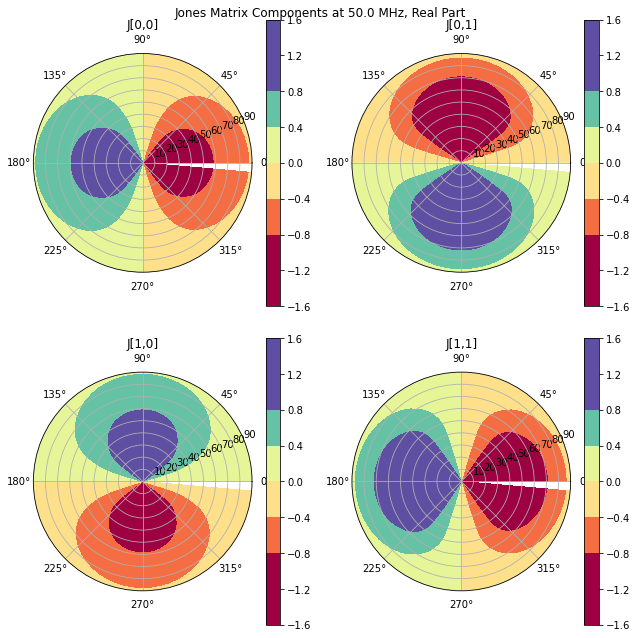

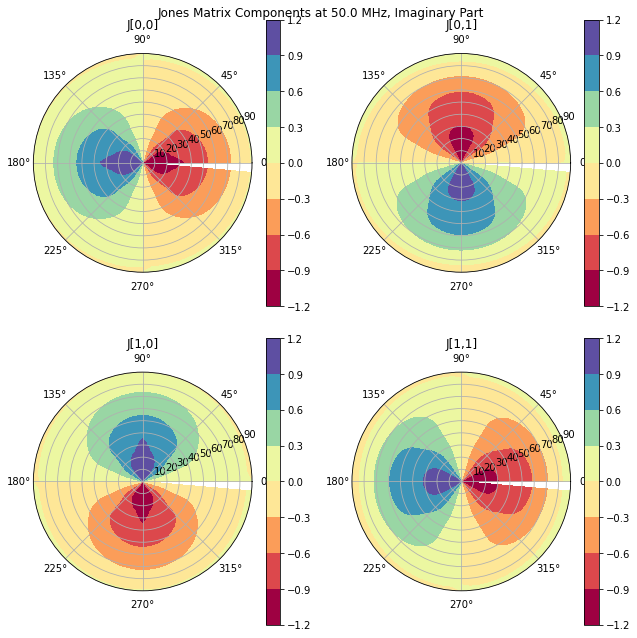

In [6]:
plot_freq = 50.
plot_freq_ind = np.where(freq_axis == plot_freq)[0][0]
use_cmap = matplotlib.cm.get_cmap("Spectral").copy()
use_cmap.set_bad(color='whitesmoke')
r_plot, theta_plot = np.meshgrid(za_axis, az_axis)

fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='polar'), figsize=(9,9))
for pol1 in [0, 1]:
    for pol2 in [0, 1]:
        contourplot = ax[pol1, pol2].contourf(np.radians(theta_plot), r_plot, np.real(jones[pol1, pol2, plot_freq_ind, :, :]).T, vmin=-1, vmax=1, cmap=use_cmap)
        contourplot.set_clim(vmin=-1, vmax=1)
        fig.colorbar(contourplot, ax=ax[pol1, pol2])
        ax[pol1, pol2].set_title(f'J[{pol1},{pol2}]')
fig.tight_layout()
fig.suptitle(f"Jones Matrix Components at {plot_freq} MHz, Real Part")
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='polar'), figsize=(9,9))
for pol1 in [0, 1]:
    for pol2 in [0, 1]:
        contourplot = ax[pol1, pol2].contourf(np.radians(theta_plot), r_plot, np.imag(jones[pol1, pol2, plot_freq_ind, :, :]).T, vmin=-1, vmax=1, cmap=use_cmap)
        contourplot.set_clim(vmin=-1, vmax=1)
        fig.colorbar(contourplot, ax=ax[pol1, pol2])
        ax[pol1, pol2].set_title(f'J[{pol1},{pol2}]')
fig.tight_layout()
fig.suptitle(f"Jones Matrix Components at {plot_freq} MHz, Imaginary Part")
plt.show()

# Format as beam amplitude and plot

In [7]:
za_axis = np.arange(0., 90.+5., 5.)
az_axis = np.arange(0., 360., 5.)
freq_axis = np.arange(20., 80.+10., 10.)
beam_amplitude = np.full((2, len(freq_axis), len(za_axis), len(az_axis)), np.nan, dtype=float)

for point in range(npoints):
    za_ind = np.where(za_axis == za_deg[point])
    freq_ind = np.where(freq_axis == freq_mhz[point])
    for pol in range(2):
        use_az = az_deg[point]
        if pol == 0:
            use_az = 90.-use_az  # Q pol is rotated 90 degrees
        use_az_quadrants = [use_az, 180. - use_az, 180. + use_az, 360. - use_az]
        for use_az_quad in use_az_quadrants:
            az_inds = np.where(az_axis == use_az_quad)
            beam_amplitude[pol, freq_ind, za_ind, az_inds] = np.sqrt(np.abs(jones_theta[point])**2.+np.abs(jones_phi[point])**2.)

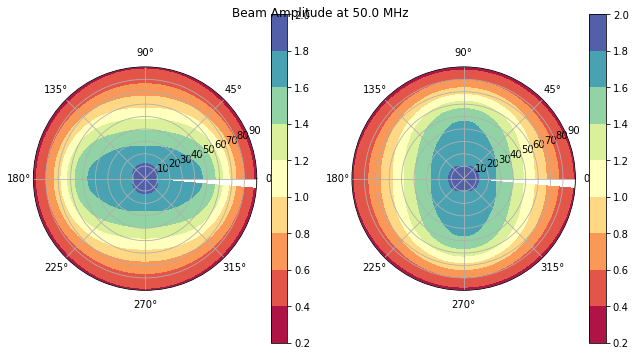

In [8]:
plot_freq = 50.
plot_freq_ind = np.where(freq_axis == plot_freq)[0][0]
use_cmap = matplotlib.cm.get_cmap("Spectral").copy()
use_cmap.set_bad(color='whitesmoke')
r_plot, theta_plot = np.meshgrid(za_axis, az_axis)
vmin = np.nanmin(beam_amplitude)
vmax = np.nanmax(beam_amplitude)

fig, ax = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'), figsize=(9,5))
for pol in [0, 1]:
    contourplot = ax[pol].contourf(np.radians(theta_plot), r_plot, np.real(beam_amplitude[pol, plot_freq_ind, :, :]).T, vmin=vmin, vmax=vmax, cmap=use_cmap)
    contourplot.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(contourplot, ax=ax[pol])
    ax[pol].set_title("")
fig.tight_layout()
fig.suptitle(f"Beam Amplitude at {plot_freq} MHz")
plt.show()

20.0


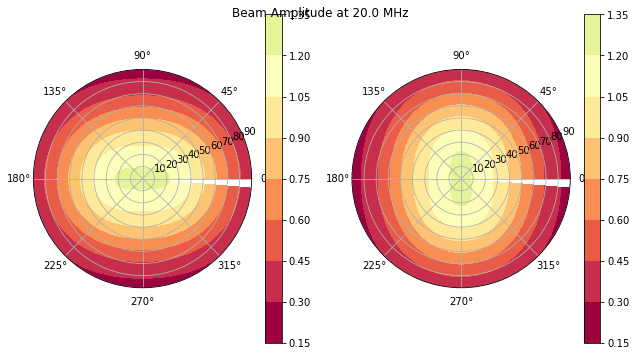

In [12]:
plot_freq = np.min(freq_axis)
plot_freq_ind = np.where(freq_axis == plot_freq)[0][0]
use_cmap = matplotlib.cm.get_cmap("Spectral").copy()
use_cmap.set_bad(color='whitesmoke')
r_plot, theta_plot = np.meshgrid(za_axis, az_axis)
vmin = np.nanmin(beam_amplitude)
vmax = np.nanmax(beam_amplitude)
print(plot_freq)

fig, ax = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'), figsize=(9,5))
for pol in [0, 1]:
    contourplot = ax[pol].contourf(np.radians(theta_plot), r_plot, np.real(beam_amplitude[pol, plot_freq_ind, :, :]).T, vmin=vmin, vmax=vmax, cmap=use_cmap)
    contourplot.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(contourplot, ax=ax[pol])
    ax[pol].set_title("")
fig.tight_layout()
fig.suptitle(f"Beam Amplitude at {plot_freq} MHz")
plt.show()

80.0


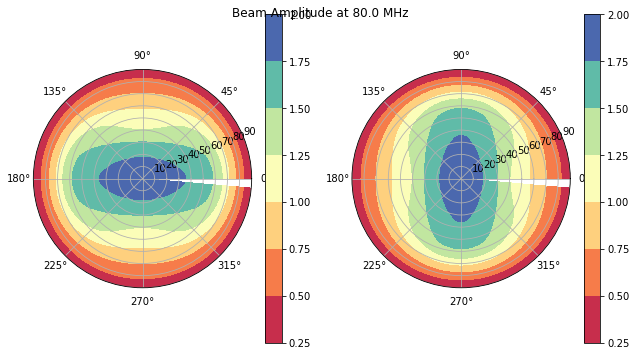

In [13]:
plot_freq = np.max(freq_axis)
plot_freq_ind = np.where(freq_axis == plot_freq)[0][0]
use_cmap = matplotlib.cm.get_cmap("Spectral").copy()
use_cmap.set_bad(color='whitesmoke')
r_plot, theta_plot = np.meshgrid(za_axis, az_axis)
vmin = np.nanmin(beam_amplitude)
vmax = np.nanmax(beam_amplitude)
print(plot_freq)

fig, ax = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'), figsize=(9,5))
for pol in [0, 1]:
    contourplot = ax[pol].contourf(np.radians(theta_plot), r_plot, np.real(beam_amplitude[pol, plot_freq_ind, :, :]).T, vmin=vmin, vmax=vmax, cmap=use_cmap)
    contourplot.set_clim(vmin=vmin, vmax=vmax)
    fig.colorbar(contourplot, ax=ax[pol])
    ax[pol].set_title("")
fig.tight_layout()
fig.suptitle(f"Beam Amplitude at {plot_freq} MHz")
plt.show()